## Eng+Wales model MCMC post-process

This is the MCMC postprocess notebook.

Outputs of this notebook:
(same as `mcmcPost` notebook with added `tWin` label in filename)

As for all mcmcPost notebooks, this requires as *input* a `.pik` file with results form MCMC.
These files are very large in general and are not provided in this repo.  This notebook *will not execute correctly* unless such a file is provided.

** Note carefully ** : internal details of .pik files that are created by the MCMC notebook may be affected by changes to pyross source code.  It is therefore useful to keep track of the specific commitID used for a given run.  I am using git commit `be4eabc` .

### start notebook

(the following line is for efficient parallel processing)

In [1]:
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 
import pandas as pd
import matplotlib.image as mpimg
import pickle
import os
import pprint
import scipy.stats

In [3]:
#print(pyross.__file__)
#print(os.getcwd())

In [4]:
#from   ew_fns import *
from   uk_v2a_fns import *  ## these are exactly the same functions as ew_fns, 
                            ## imported like this for compatibility with saved pik files (legacy)
import expt_params_local
import model_local

In [5]:
verboseMod=False    ## print ancillary info about the model?

## time unit is one week
daysPerWeek = 7.0

## these are params that might be varied in different expts
exptParams = expt_params_local.getLocalParams() 

## over-ride params for inference window
exptParams['timeLast'] = 10
exptParams['forecastTime'] = 11-exptParams['timeLast']
exptParams['pikFileRoot'] += '-tWin10'

pprint.pprint(exptParams)

## this is used for filename handling throughout
pikFileRoot = exptParams['pikFileRoot']

{'careFile': '../data/CareHomes.csv',
 'chooseCM': 'fumanelliEtAl',
 'dataFile': '../data/OnsData.csv',
 'estimatorTol': 1e-08,
 'exCare': True,
 'forecastTime': 1,
 'freeInitPriors': ['E', 'A', 'Is1', 'Is2', 'Is3'],
 'infOptions': {'cma_population': 32,
                'cma_processes': None,
                'ftol': 5e-05,
                'global_atol': 1.0,
                'global_max_iter': 1500,
                'local_max_iter': 400},
 'inferBetaNotAi': True,
 'numCohorts': 16,
 'numCohortsPopData': 19,
 'pikFileRoot': 'ewMod-tWin10',
 'popFile': '../data/EWAgeDistributedNew.csv',
 'timeLast': 10,
 'timeZero': 0}


### convenience

In [6]:
np.set_printoptions(precision=3) 
pltAuto = True
plt.rcParams.update({'figure.autolayout': pltAuto})
plt.rcParams.update({'font.size': 14})

## LOAD MODEL

In [7]:
loadModel = model_local.loadModel(exptParams,daysPerWeek,verboseMod) 

## should use a dictionary but...
[ numCohorts, fi, N, Ni, model_spec, estimator, contactBasis, interventionFn,
   modParams, priorsAll, initPriorsLinMode, obsDeath, fltrDeath, 
   simTime, deathCumulativeDat ] = loadModel

** model

{'A': {'infection': [], 'linear': [['E', 'gammaE'], ['A', '-gammaA']]},
 'E': {'infection': [['A', 'beta'],
                     ['Is1', 'beta'],
                     ['Is2', 'betaLate'],
                     ['Is3', 'betaLate']],
       'linear': [['E', '-gammaE']]},
 'Im': {'infection': [], 'linear': [['Is3', 'cfr*gammaIs3']]},
 'Is1': {'infection': [],
         'linear': [['A', 'gammaA'],
                    ['Is1', '-alphabar*gammaIs1'],
                    ['Is1', '-alpha*gammaIs1']]},
 'Is2': {'infection': [],
         'linear': [['Is1', 'alphabar*gammaIs1'], ['Is2', '-gammaIs2']]},
 'Is3': {'infection': [],
         'linear': [['Is2', 'gammaIs2'],
                    ['Is3', '-cfrbar*gammaIs3'],
                    ['Is3', '-cfr*gammaIs3']]},
 'S': {'infection': [['A', '-beta'],
                     ['Is1', '-beta'],
                     ['Is2', '-betaLate'],
                     ['Is3', '-betaLate']],
       'linear': []},
 'classes': ['S', 'E', 'A', 'Is1', 'Is2', 'Is

### helper functions for MCMC

In [8]:
def dumpPickle(pikFileRoot,sampler) :
    opFile = pikFileRoot + "-mcmc.pik"
    print('opf',opFile)
    with open(opFile, 'wb') as f: 
        pickle.dump([sampler,infResult],f)

def loadPickle(pikFileRoot) :
    ipFile = pikFileRoot + "-mcmc.pik"
    print('ipf',ipFile)
    with open(ipFile, 'rb') as f: 
        [ss,ii] = pickle.load(f)
    return [ss,ii]

### load data

In [9]:
[sampler,infResult] = loadPickle(pikFileRoot)

ipf ewMod-tWin10-mcmc.pik


### plotting helper functions for MCMC

In [10]:
def plotMCtrace(selected_dims,sampler,numTrace=None):
    # Plot the trace for these dimensions:
    plot_dim = len(selected_dims)
    fig, axes = plt.subplots(plot_dim, figsize=(12, plot_dim), sharex=True)
    samples = sampler.get_chain()
    if numTrace == None : numTrace = np.shape(samples)[1]  ## corrected index
    for ii,dd in enumerate(selected_dims):
        ax = axes[ii]
        ax.plot(samples[:, :numTrace , dd], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
    axes[-1].set_xlabel("step number");
    plt.show(fig)
    plt.close()
    
nDimMCMC = np.size(infResult['flat_params'])

def plotInterestingTraces() :
    offset = 6 # full inference
    #offset = 1 # no inference of gammas
    
    ## these are cohorts 3,7,11,15 (which includes the eldest)
    selected_dims  = [ i for i in range(3,numCohorts,4) ] 
    print('beta, cohorts',selected_dims)
    plotMCtrace(selected_dims,sampler,numTrace=40)

    print('aF, cohorts',selected_dims)
    ## index hacking.  plot aF with same cohorts as beta above
    selected_dims = [ i for i in range(numCohorts+offset+3,numCohorts+offset+numCohorts,4) ]
    plotMCtrace(selected_dims,sampler,numTrace=40)

    print('lockTime,easeFrac,lockWidth')
    selected_dims = [ i for i in range(numCohorts+offset+numCohorts,numCohorts+offset+numCohorts+3) ]
    plotMCtrace(selected_dims,sampler,numTrace=40)

    print('initConds')
    selected_dims = [ i for i in range(nDimMCMC-1-len(exptParams['freeInitPriors']),nDimMCMC) ]
    plotMCtrace(selected_dims,sampler,numTrace=40)


### MCMC traces (to check mixing)

beta, cohorts [3, 7, 11, 15]


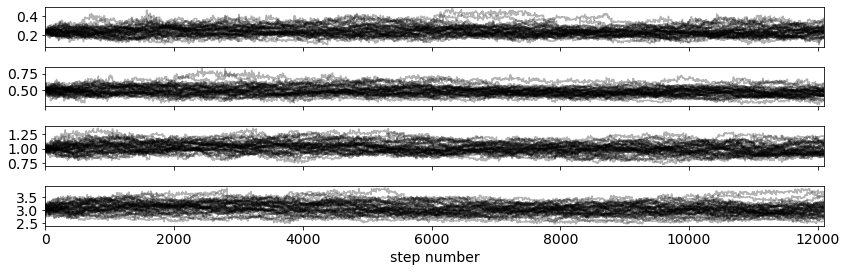

aF, cohorts [3, 7, 11, 15]


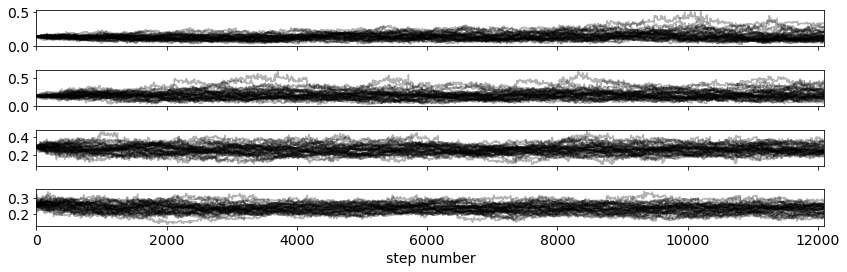

lockTime,easeFrac,lockWidth


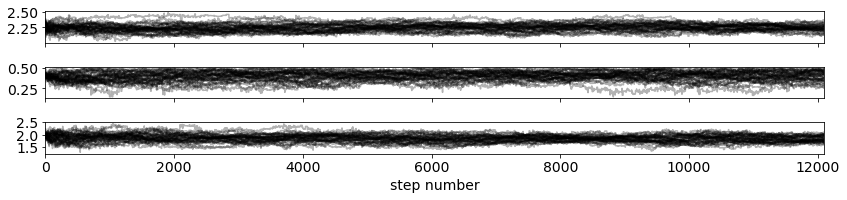

initConds


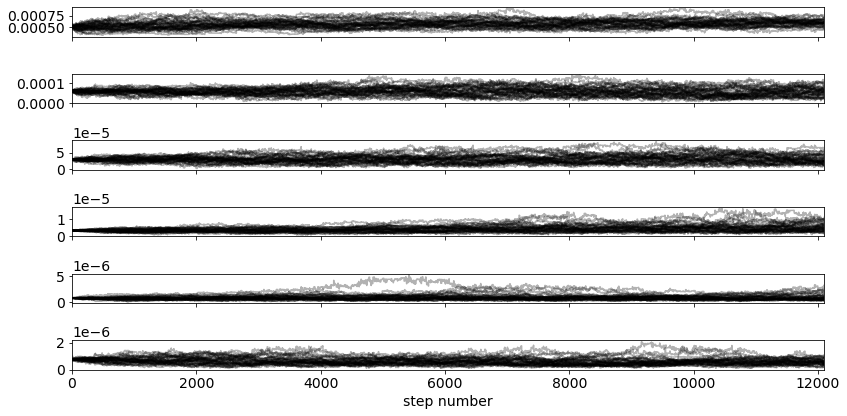

In [11]:
plotInterestingTraces()

### collect results

In [12]:
## how many samples in total?
pp = sampler.get_log_prob()
nSampleTot = np.shape(pp)[0]

## for analysis we pull discard the initial 1/3 from burn-in
## then we pull out reprsentative samples spaced by 0.1 of the total run
## (total samples come out as 6 * batch size where batch size is twice the num of inferred params)

result_mcmc = estimator.latent_infer_mcmc_process_result(sampler, obsDeath, fltrDeath, 
                                        priorsAll, 
                                        initPriorsLinMode, 
                                        generator=contactBasis, 
                                        intervention_fun=interventionFn, 
                                        discard=int(nSampleTot/3), 
                                        thin=int(nSampleTot/10) )

print("** samples",np.size(result_mcmc))

param_post_mean = pyross.utils.posterior_mean(result_mcmc)

print( '** ave logLikelihood',np.mean( [ rr['log_likelihood'] for rr in result_mcmc ] ) )
print( '** ave logPost',np.mean( [ rr['log_posterior'] for rr in result_mcmc ] ) )

** samples 564
** ave logLikelihood -346.77166967650214
** ave logPost -269.0116235452586


#### save this subset of results from MCMC

In [13]:
opFile = pikFileRoot + "-result_mcmc.pik"
print('opf',opFile)
with open(opFile, 'wb') as f: 
    pickle.dump([result_mcmc],f)

opf ewMod-tWin10-result_mcmc.pik


#### run 100 deterministic trajectories using posterior samples

In [14]:
runTime = 10
nSave = 100
saveTraj = []
for ii,rr in enumerate(result_mcmc[-nSave:]) :
    estimator.set_params(rr['params_dict'])
    estimator.set_contact_matrix( contactBasis.intervention_custom_temporal( interventionFn, 
                                                                             **rr['control_params_dict'])
                                )
    mytraj = estimator.integrate( rr['x0'], 0, runTime, runTime+1)
    saveTraj.append( mytraj )

opFile = pikFileRoot + "-traj_mcmc.pik"
print('opf',opFile)
with open(opFile, 'wb') as f: 
    pickle.dump([model_spec,saveTraj,N,numCohorts,deathCumulativeDat],f)

opf ewMod-tWin10-traj_mcmc.pik
